In [274]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

In [275]:
df = pd.read_csv("training_set.csv")
train = df.drop(['ARR_DELAY'], axis = 1)
y = np.copy(df.ARR_DELAY)
df.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,FL_NUM,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,ARR_DELAY
0,0,2,1020,11,8,373,"2,701",11,19930,2017-01-03,...,879,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,-11
1,1,6,1220,13,9,183,"1,171",5,19805,2017-01-28,...,2491,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,1
2,2,6,945,48,6,355,"2,552",11,19930,2017-01-21,...,172,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,18
3,3,1,1437,17,8,136,967,4,19977,2017-01-23,...,2030,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,0
4,4,1,830,37,7,114,534,3,19393,2017-01-02,...,3812,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,197


# Data Cleaning

In [276]:
def cleaning(data):
    for i in range(len(data)):
        #print i
        data.loc[i, 'DISTANCE'] = data.loc[i, 'DISTANCE'].replace(',','')
        data.loc[i, 'DISTANCE'] = int(data.loc[i, 'DISTANCE'])

        date = data.loc[i, 'FL_DATE']
        data.loc[i, 'FL_DATE'] = datetime.datetime.strptime(date, '%Y-%m-%d')

        data.loc[i, 'DAY_OF_MONTH'] = data.loc[i, 'FL_DATE'].day
        data.loc[i, 'MONTH'] = data.loc[i, 'FL_DATE'].month

    return data

In [277]:
train = cleaning(train)
train.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH
0,0,2,1020,11,8,373,2701,11,19930,2017-01-03 00:00:00,...,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,3.0,1.0
1,1,6,1220,13,9,183,1171,5,19805,2017-01-28 00:00:00,...,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,28.0,1.0
2,2,6,945,48,6,355,2552,11,19930,2017-01-21 00:00:00,...,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,21.0,1.0
3,3,1,1437,17,8,136,967,4,19977,2017-01-23 00:00:00,...,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,23.0,1.0
4,4,1,830,37,7,114,534,3,19393,2017-01-02 00:00:00,...,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,2.0,1.0


# Data Pre-processing

In [278]:
def pre_processing(data):
    from sklearn.preprocessing import LabelEncoder  
    
    # Creating bins for continuous values in CRS_DEP_TIME feature
    CRS_DEP_TIME__bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
    data['CRS_DEP_TIME'] = pd.cut(data['CRS_DEP_TIME'], CRS_DEP_TIME__bins)

    TAXI_OUT__bins = [0, 20, 40, 60, 80, 150]
    data['TAXI_OUT'] = pd.cut(data['TAXI_OUT'], TAXI_OUT__bins)
    
    TAXI_IN__bins = [0, 10, 20, 30, 40, 85]
    data['TAXI_IN'] = pd.cut(data['TAXI_IN'], TAXI_IN__bins)
    
    ACTUAL_ELAPSED_TIME__bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 650]
    data['ACTUAL_ELAPSED_TIME'] = pd.cut(data['ACTUAL_ELAPSED_TIME'], ACTUAL_ELAPSED_TIME__bins)
    
    DISTANCE__bins = np.arange(0, 5100, 100)
    data['DISTANCE'] = pd.cut(data['DISTANCE'], DISTANCE__bins)
    
    # Changing string to int values
    le = LabelEncoder()
    data['ORIG_STATE'] = le.fit_transform(data['ORIGIN_STATE_ABR'])

    # Using Python's Dictionary as Hash-Map to to encode states as integers
    # Using the same encoding for Destination State as well (for consistency)
    states = {}

    for i in range(len(data)):
        key = data.loc[i, 'ORIGIN_STATE_ABR']
        value = data.loc[i, 'ORIG_STATE']
        states[key] = value

    for i in range(len(data)):
        val = data.loc[i, 'DEST_STATE_ABR']
        data.loc[i, 'DEST_STATE'] = states[val]
        data.loc[i, 'DEP_TIME'] = data.loc[i, 'CRS_DEP_TIME'].mid
        data.loc[i, 'OUT_TAXI'] = data.loc[i, 'TAXI_OUT'].mid
        data.loc[i, 'IN_TAXI'] = data.loc[i, 'TAXI_IN'].mid
        data.loc[i, 'ELAPSED_TIME'] = data.loc[i, 'ACTUAL_ELAPSED_TIME'].mid
        data.loc[i, 'NEW_DIST_GROUP'] = data.loc[i, 'DISTANCE'].mid

    return data

train = pre_processing(train)
train.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,0,2,"(900, 1200]","(0, 20]","(0, 10]","(360, 390]","(2700, 2800]",11,19930,2017-01-03 00:00:00,...,NaN,3.0,1.0,47,9.0,1050.0,10.0,5.0,375.0,2750.0
1,1,6,"(1200, 1500]","(0, 20]","(0, 10]","(180, 210]","(1100, 1200]",5,19805,2017-01-28 00:00:00,...,NaN,28.0,1.0,4,42.0,1350.0,10.0,5.0,195.0,1150.0
2,2,6,"(900, 1200]","(40, 60]","(0, 10]","(330, 360]","(2500, 2600]",11,19930,2017-01-21 00:00:00,...,NaN,21.0,1.0,0,3.0,1050.0,50.0,5.0,345.0,2550.0
3,3,1,"(1200, 1500]","(0, 20]","(0, 10]","(120, 150]","(900, 1000]",4,19977,2017-01-23 00:00:00,...,NaN,23.0,1.0,4,5.0,1350.0,10.0,5.0,135.0,950.0
4,4,1,"(600, 900]","(20, 40]","(0, 10]","(90, 120]","(500, 600]",3,19393,2017-01-02 00:00:00,...,NaN,2.0,1.0,8,44.0,750.0,30.0,5.0,105.0,550.0


## Removing redundant features

In [279]:
# Dropping the un-cleaned columns (ONLY FOR NOW !!!)
redundant_cols = ['UID', 'FL_NUM','FIRST_DEP_TIME', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_STATE_ABR', 
                  'UNIQUE_CARRIER']
new_train = train.drop(redundant_cols, axis=1)

# These features have been used to create new features which made more sense
treated_cols = ['FL_DATE', 'ORIGIN_STATE_ABR', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'TAXI_OUT',
               'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE']
new_train = new_train.drop(treated_cols, axis=1)

new_train.head()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,2,11,19930,30559,32982,3.0,1.0,47,9.0,1050.0,10.0,5.0,375.0,2750.0
1,6,5,19805,33570,30194,28.0,1.0,4,42.0,1350.0,10.0,5.0,195.0,1150.0
2,6,11,19930,30299,30466,21.0,1.0,0,3.0,1050.0,50.0,5.0,345.0,2550.0
3,1,4,19977,32457,30325,23.0,1.0,4,5.0,1350.0,10.0,5.0,135.0,950.0
4,1,3,19393,30397,30852,2.0,1.0,8,44.0,750.0,30.0,5.0,105.0,550.0


In [14]:
new_train.to_csv("Clean_train.csv")

In [15]:
new_train.describe()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,FL_NUM,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,2762.436164,3.936469,1328.823458,16.662391,7.545714,140.867033,3.870902,19905.026675,31749.620648,31731.724903,2155.427001,15.917125,6.531460,20.378334,20.402769
std,1584.960626,1.992766,485.447437,9.187371,6.018327,76.230276,2.445169,381.263178,1281.001009,1287.236306,1750.438105,8.892493,3.448335,15.068905,15.010189
min,0.000000,1.000000,15.000000,3.000000,1.000000,31.000000,1.000000,19393.000000,30073.000000,30070.000000,2.000000,1.000000,1.000000,0.000000,0.000000
25%,1389.500000,2.000000,914.000000,11.000000,4.000000,83.000000,2.000000,19790.000000,30647.000000,30647.000000,739.000000,8.000000,4.000000,7.000000,7.000000
50%,2768.000000,4.000000,1325.000000,14.000000,6.000000,123.000000,3.000000,19805.000000,31454.000000,31453.000000,1677.000000,16.000000,7.000000,17.000000,17.000000
75%,4131.500000,6.000000,1730.000000,19.000000,9.000000,175.000000,5.000000,20304.000000,32467.000000,32535.000000,3077.000000,24.000000,10.000000,33.000000,33.000000
max,5495.000000,7.000000,2359.000000,146.000000,84.000000,646.000000,11.000000,21171.000000,35991.000000,35841.000000,7437.000000,31.000000,12.000000,49.000000,49.000000


In [16]:
### Non-unique values in the feature 'FL_NUM
len(new_train) - len(new_train['FL_NUM'].unique())

1944

In [17]:
cols = []
for col in new_train:
    cols.append(col)
    # Printing the data type of last element of every feature
    print col, "\t\t", type(new_train[col][len(new_train)-1])

UID 		<type 'numpy.int64'>
DAY_OF_WEEK 		<type 'numpy.int64'>
CRS_DEP_TIME 		<type 'numpy.int64'>
TAXI_OUT 		<type 'numpy.int64'>
TAXI_IN 		<type 'numpy.int64'>
ACTUAL_ELAPSED_TIME 		<type 'numpy.int64'>
DISTANCE 		<type 'int'>
DISTANCE_GROUP 		<type 'numpy.int64'>
AIRLINE_ID 		<type 'numpy.int64'>
ORIGIN_CITY_MARKET_ID 		<type 'numpy.int64'>
DEST_CITY_MARKET_ID 		<type 'numpy.int64'>
FL_NUM 		<type 'numpy.int64'>
DAY_OF_MONTH 		<type 'numpy.float64'>
MONTH 		<type 'numpy.float64'>
ORIG_STATE 		<type 'numpy.int64'>
DEST_STATE 		<type 'numpy.float64'>


# Data Distribution

### Box-Plot

Outliers: 350


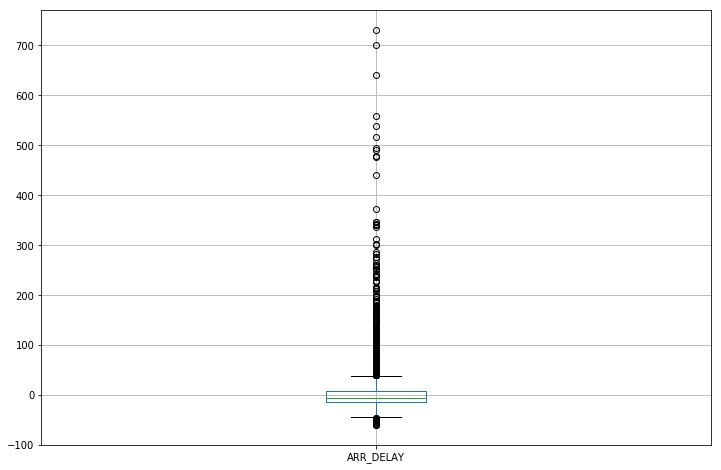

In [18]:
# Distribution of 'Arrival Delay'
plt.figure(figsize = (12, 8))
df.boxplot(column=['ARR_DELAY']) 

count = 0
for i in range(len(df)):
    if df.ARR_DELAY[i] > 50:
        count += 1
        
print "Outliers:", count

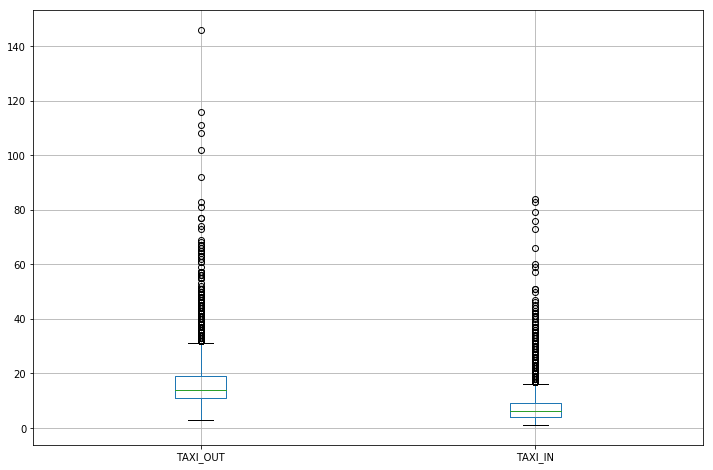

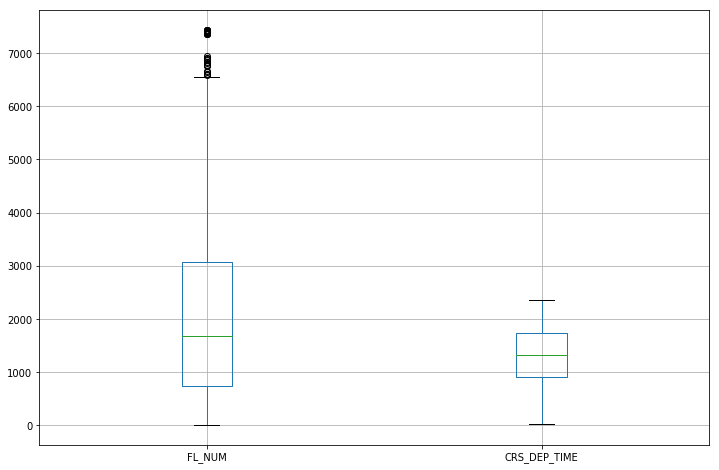

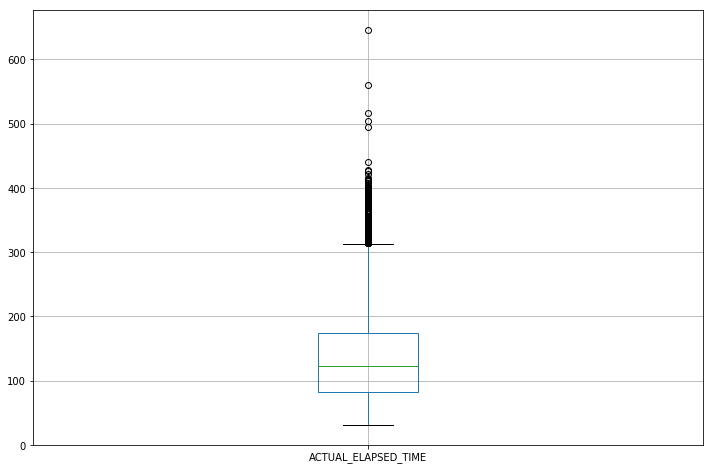

In [19]:
ax1 = plt.figure(figsize = (12, 8))
ax1 = train.boxplot(column=['TAXI_OUT', 'TAXI_IN']) 

ax2 = plt.figure(figsize = (12, 8))
ax2 = train.boxplot(column=['FL_NUM', 'CRS_DEP_TIME']) 

ax3 = plt.figure(figsize = (12, 8))
ax3 = train.boxplot(column=['ACTUAL_ELAPSED_TIME']) 

### Scatter-Plot

DAY_OF_WEEK


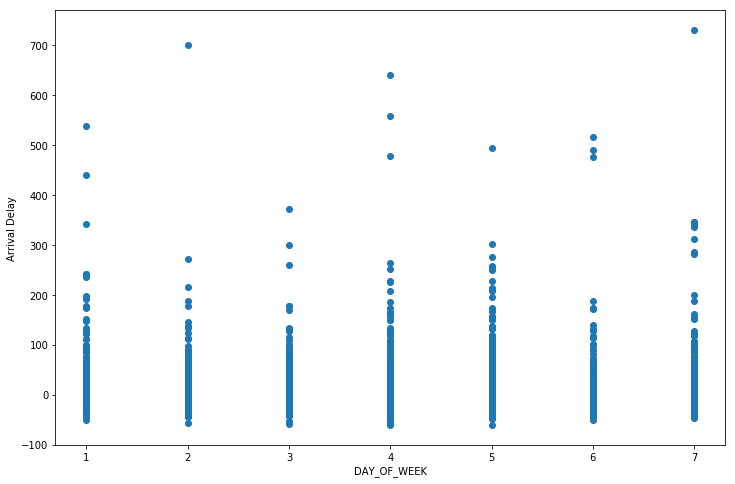

CRS_DEP_TIME


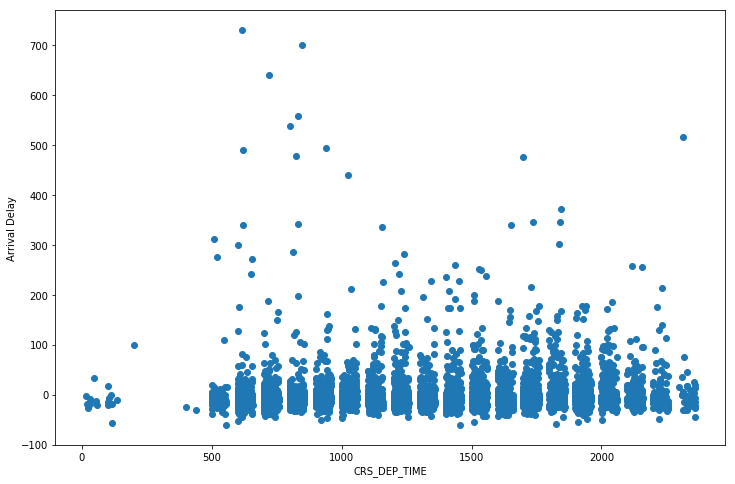

TAXI_OUT


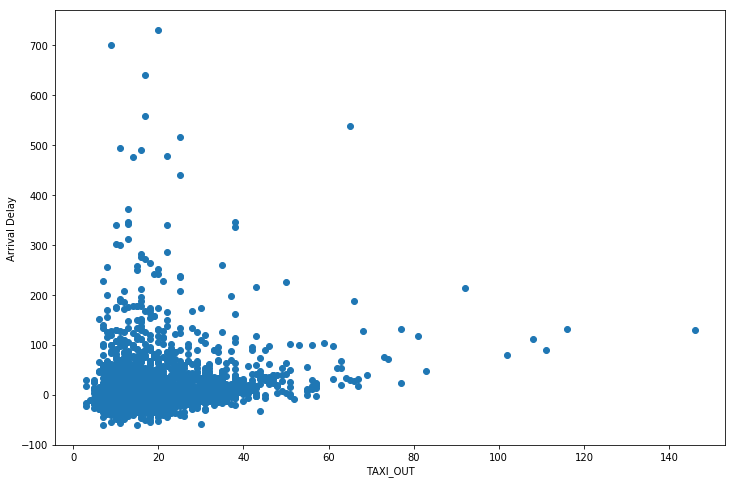

TAXI_IN


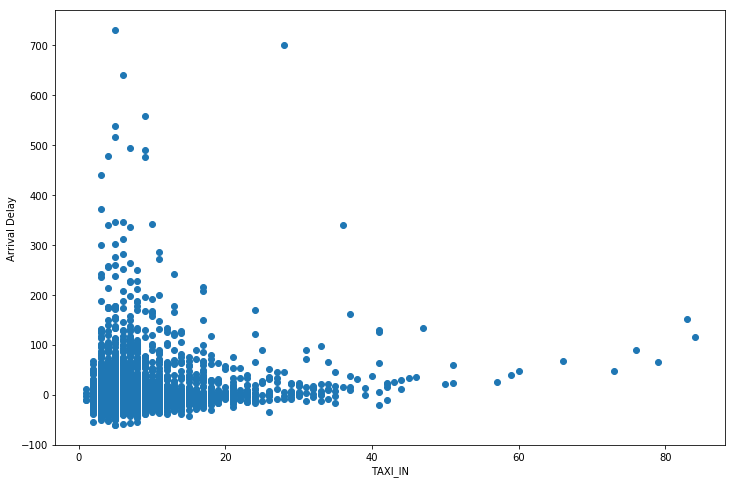

ACTUAL_ELAPSED_TIME


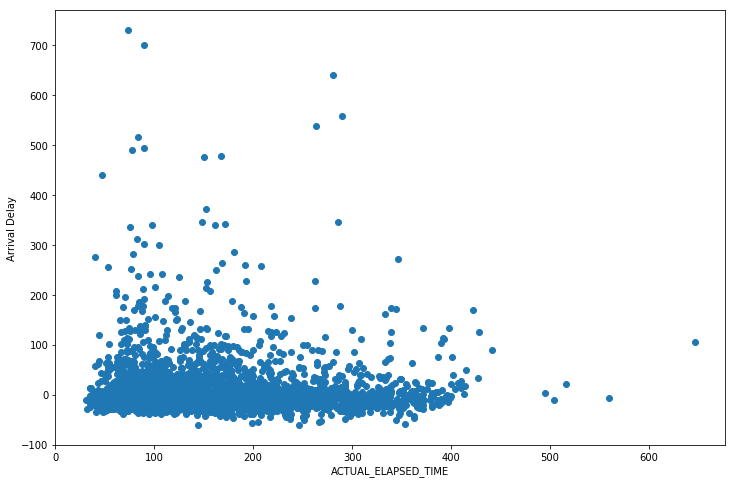

DISTANCE_GROUP


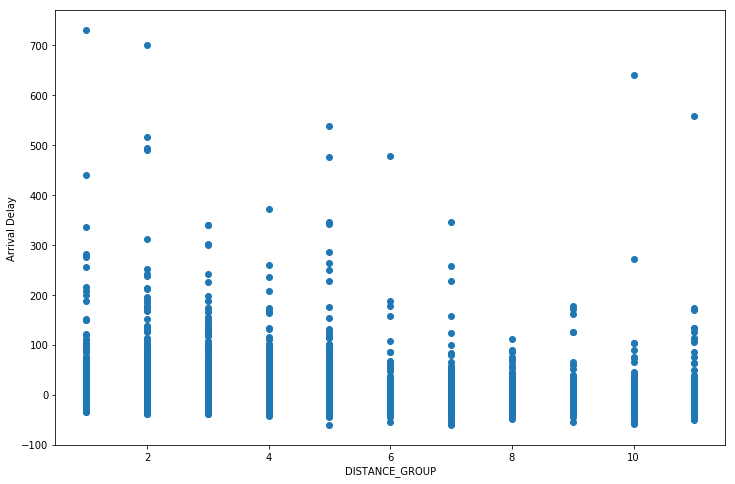

In [20]:
cols = ['DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE_GROUP']
for col in cols:
    print col
    feat = train[col]
    try:
        plt.figure(figsize = (12, 8))
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

UID


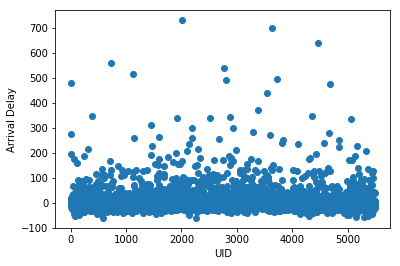

DAY_OF_WEEK


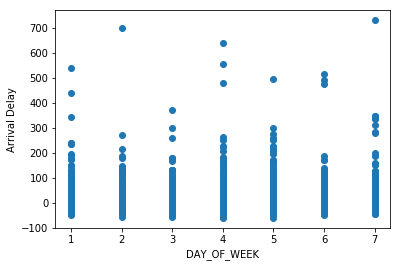

CRS_DEP_TIME


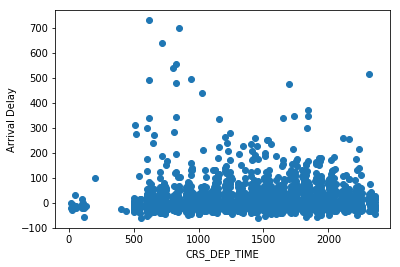

TAXI_OUT


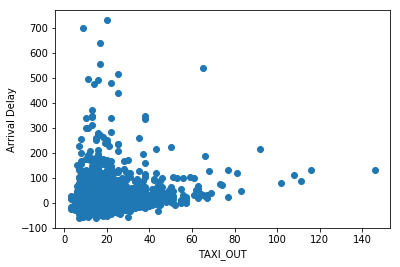

TAXI_IN


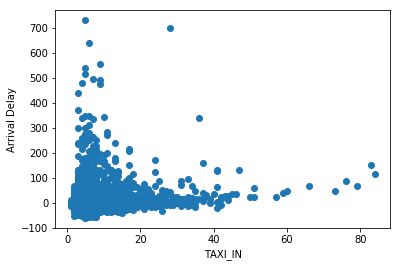

ACTUAL_ELAPSED_TIME


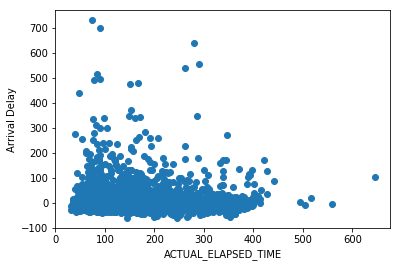

DISTANCE


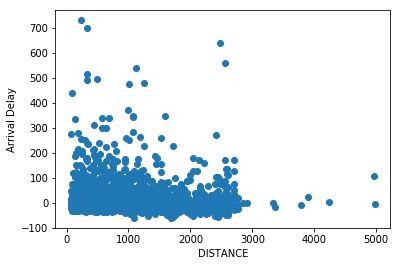

DISTANCE_GROUP


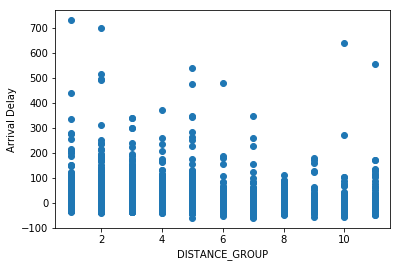

AIRLINE_ID


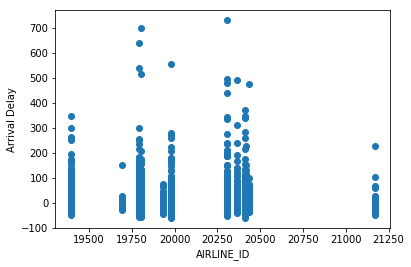

FL_DATE


TypeError: float() argument must be a string or a number

TypeError: float() argument must be a string or a number

In [61]:
for col in train:
    print col
    feat = train[col]
    try:
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

# Mutual Information

In [287]:
### Plotting function for Information Gain of each feature

def plot_info(res, title):
    
    feat = res.keys()
    imp = res.values()
    # Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(feat)), imp)
    plt.xticks(range(len(feat)), feat, rotation=30)
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Importance')
    plt.title(title)
    plt.show()

In [288]:
new_train.head()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,2,11,19930,30559,32982,3.0,1.0,47,9.0,1050.0,10.0,5.0,375.0,2750.0
1,6,5,19805,33570,30194,28.0,1.0,4,42.0,1350.0,10.0,5.0,195.0,1150.0
2,6,11,19930,30299,30466,21.0,1.0,0,3.0,1050.0,50.0,5.0,345.0,2550.0
3,1,4,19977,32457,30325,23.0,1.0,4,5.0,1350.0,10.0,5.0,135.0,950.0
4,1,3,19393,30397,30852,2.0,1.0,8,44.0,750.0,30.0,5.0,105.0,550.0


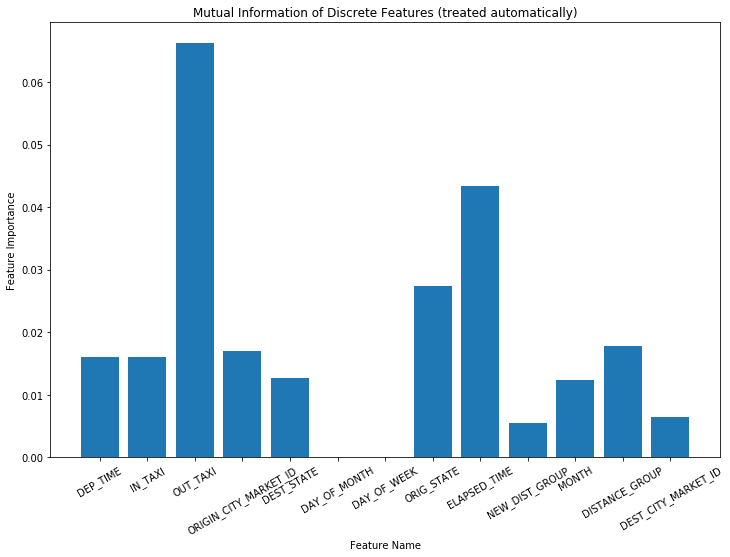

In [289]:
from sklearn.feature_selection import mutual_info_regression

discrete_feat = ['DAY_OF_WEEK', 'DISTANCE_GROUP', 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'ORIG_STATE',
                'DAY_OF_MONTH', 'MONTH', 'DEST_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME', 'NEW_DIST_GROUP']
dis_mutual_info = mutual_info_regression(new_train[discrete_feat], y, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated automatically)")

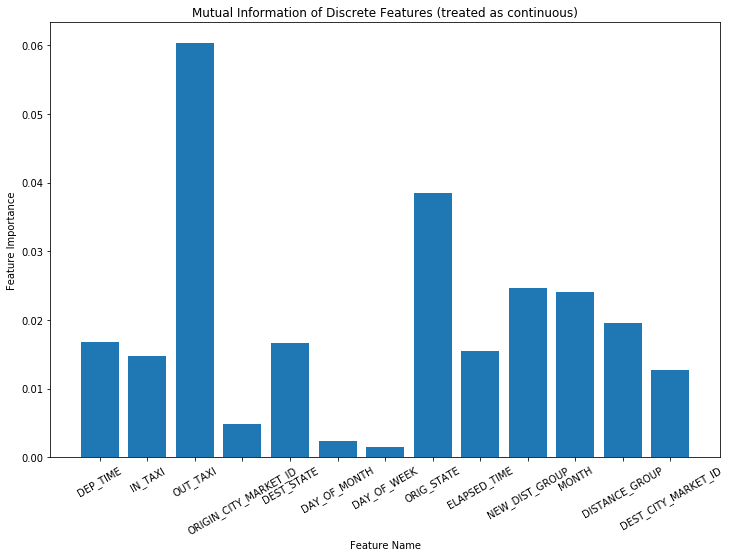

In [290]:
dis_mutual_info = mutual_info_regression(new_train[discrete_feat], y, discrete_features = False, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as continuous)")

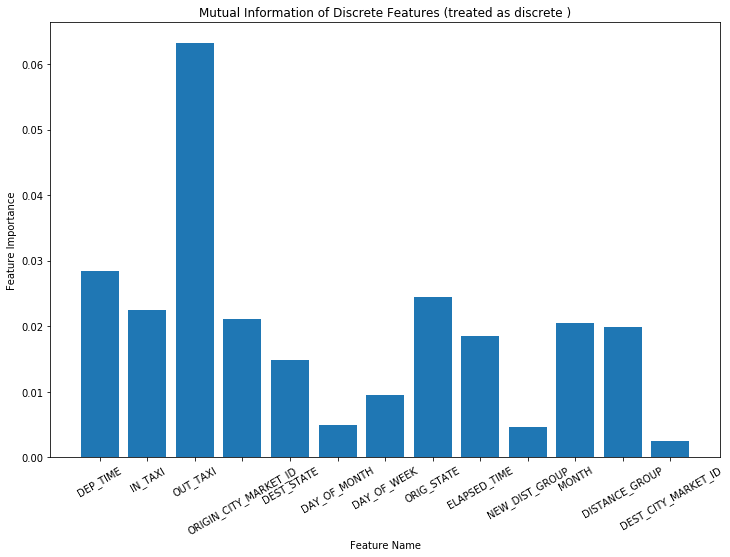

In [291]:
dis_mutual_info = mutual_info_regression(new_train[discrete_feat], y,   discrete_features = True, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as discrete )")

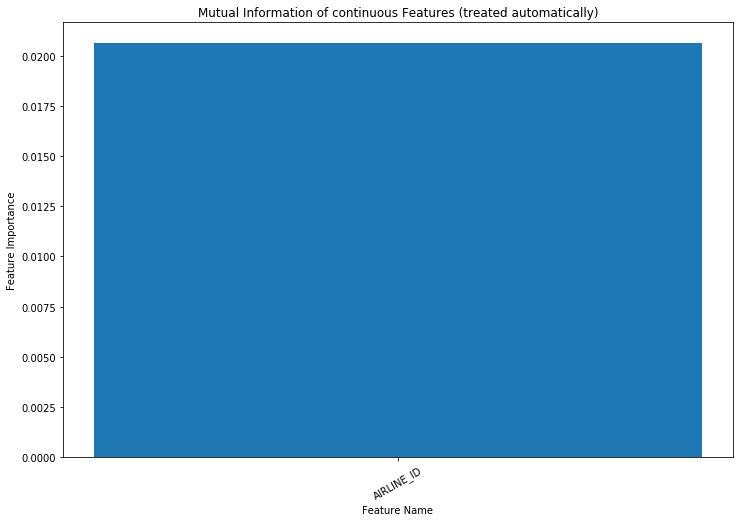

In [292]:
cont_train = new_train.drop(discrete_feat, axis = 1)
cont_mutual_info = mutual_info_regression(cont_train, y, copy = True)

cont_res = dict(zip(cont_train.columns.values, cont_mutual_info))
plot_info(cont_res, "Mutual Information of continuous Features (treated automatically)")

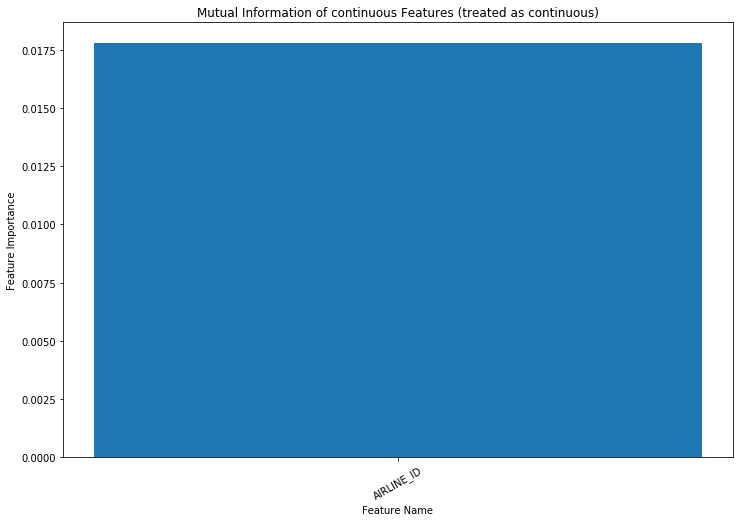

In [293]:
cont_train = new_train.drop(discrete_feat, axis = 1)
cont_mutual_info = mutual_info_regression(cont_train, y,  discrete_features = False, copy = True)

cont_res = dict(zip(cont_train.columns.values, cont_mutual_info))
plot_info(cont_res, "Mutual Information of continuous Features (treated as continuous)")

In [120]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(mutual_info_regression, k=5)
kbest.fit(new_train, y)
kbest.get_support(indices=True)

array([ 3,  5,  7, 13, 14])

In [43]:
i = 0
for col in new_train:
    print i, col
    i += 1

0 UID
1 DAY_OF_WEEK
2 CRS_DEP_TIME
3 TAXI_OUT
4 TAXI_IN
5 ACTUAL_ELAPSED_TIME
6 DISTANCE
7 DISTANCE_GROUP
8 AIRLINE_ID
9 ORIGIN_CITY_MARKET_ID
10 DEST_CITY_MARKET_ID
11 FL_NUM
12 DAY_OF_MONTH
13 MONTH
14 ORIG_STATE
15 DEST_STATE


# Predictive Modelling

### Removing features with low Information Gain

In [63]:
bad_feat = ['DAY_OF_MONTH', 'DEST_CITY_MARKET_ID', 'FL_NUM', 'UID']
trimmed_train = new_train.drop(bad_feat, axis=1)
trimmed_train.head()

,DAY_OF_WEEK,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,MONTH,ORIG_STATE,DEST_STATE
0,2,11,8,373,2701,11,19930,30559,1.0,47,9.0
1,6,13,9,183,1171,5,19805,33570,1.0,4,42.0
2,6,48,6,355,2552,11,19930,30299,1.0,0,3.0
3,1,17,8,136,967,4,19977,32457,1.0,4,5.0
4,1,37,7,114,534,3,19393,30397,1.0,8,44.0


## 1. Predicting from the mean

In [76]:
x = np.copy(trimmed_train)

# 20% split to test set as it will be used in the very end
x_train, x_test, y_train, y_test = np.array(train_test_split(x, y, train_size = 0.7))

y_train = np.array(y_train)
mean = y_train.mean()
preds = []

for i in range(len(y_test)):
    preds.append(mean)
    
print "Mean Squared Error:", mse(y_test, preds)

Mean Squared Error: 2207.22646521


# 2. Linear Regression

In [153]:
x = trimmed_train[['DISTANCE_GROUP']].values
x_train, x_test, y_train, y_test = np.array(train_test_split(x, y, train_size = 0.7))

In [154]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)

MSE = mse(y_test, preds)
print MSE

1942.60323027


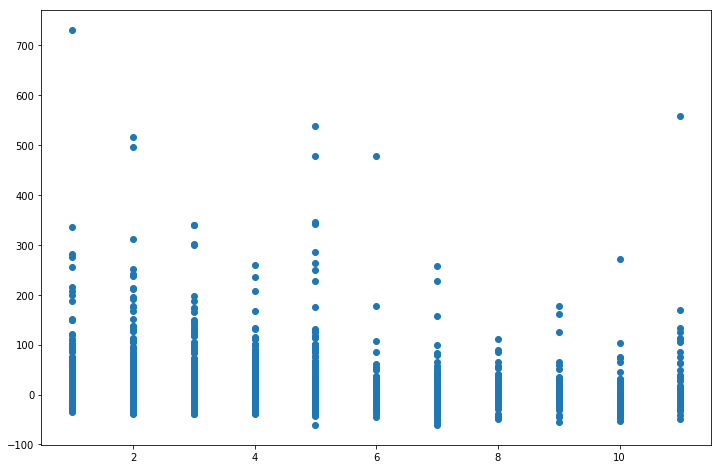

In [155]:
plt.figure(figsize = (12, 8))
plt.scatter(x_train, y_train)

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold


def Linear_Regression(train, y, folds):
    
    MSE_stats = []

    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for tr, te in kf:
            x_train = [train[ii] for ii in tr]
            y_train = [y[ii] for ii in tr]
            x_test = [train[ii] for ii in te]
            y_test = [y[ii] for ii in te]

        LR_model = LinearRegression()
        LR_model.fit(x_train, y_train)
        preds = LR_model.predict(x_test)

        MSE = mse(y_test, preds)
        MSE_list.append(MSE)

        MSE_stats.append(MSE_list)
    
    return MSE_stats

In [93]:
train_set = np.copy(new_train)
MSE_stats = Linear_Regression(train_set, y, 5)
print MSE_stats
np.mean(MSE_stats)

[[2189.3501087513328], [3268.4842217107648], [2203.2693972762722], [2198.0382624864737], [1695.3327461955846]]


2310.8949472840859

## 2. Decision Tree

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

leaves = [1, 2, 3, 5, 7, 10, 15, 30, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000, 2000, 5000, 8000, 10000]

train_set = np.copy(trimmed_train)

for i in leaves:
    
    DT_model = DecisionTreeRegressor(min_samples_leaf=i)
    DT_model.fit(x_train, y_train)
    preds = DT_model.predict(x_test)
    cv_score = cross_val_score(DT_model, train_set, y, cv = 5, scoring='neg_mean_squared_error')
    print "Leaves: ", i, "Squared error: ", -cv_score.mean()

Leaves:  1 Squared error:  4522.32402741
Leaves:  2 Squared error:  3559.41418859
Leaves:  3 Squared error:  2974.46432327
Leaves:  5 Squared error:  2699.61526014
Leaves:  7 Squared error:  2511.84602895
Leaves:  10 Squared error:  2444.85240706
Leaves:  15 Squared error:  2317.40264633
Leaves:  30 Squared error:  2130.56616722
Leaves:  50 Squared error:  2067.05258876
Leaves:  70 Squared error:  2040.84126514
Leaves:  100 Squared error:  2029.16820777
Leaves:  200 Squared error:  2010.02944258
Leaves:  500 Squared error:  2005.15456258
Leaves:  1000 Squared error:  2023.82230699
Leaves:  2000 Squared error:  2062.58142851
Leaves:  3000 Squared error:  2062.58142851
Leaves:  4000 Squared error:  2062.58142851
Leaves:  5000 Squared error:  2062.58142851
Leaves:  1000 Squared error:  2023.82230699
Leaves:  2000 Squared error:  2062.58142851
Leaves:  5000 Squared error:  2062.58142851
Leaves:  8000 Squared error:  2062.58142851
Leaves:  10000 Squared error:  2062.58142851


### Information Gain from Decision tree

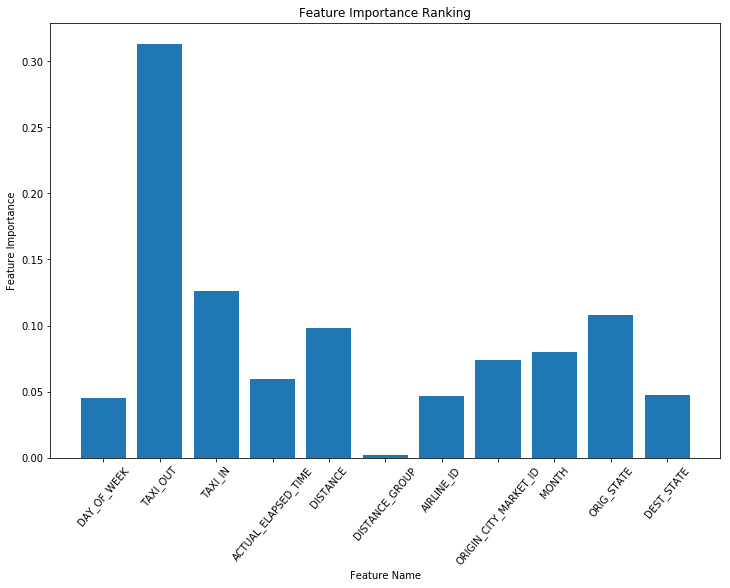

In [115]:
DT_model = DecisionTreeRegressor(min_samples_leaf=20)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( trimmed_train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

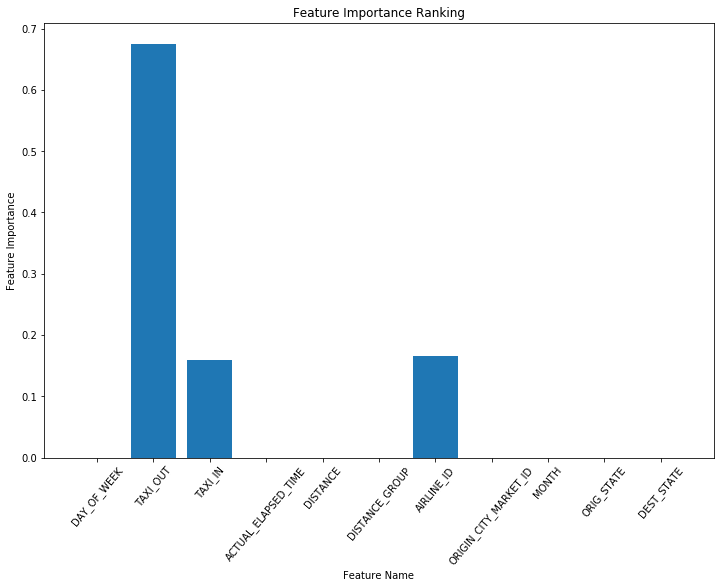

In [116]:
DT_model = DecisionTreeRegressor(min_samples_leaf=500)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( trimmed_train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

# K-Nearest Neighbors

In [118]:
from sklearn.neighbors import KNeighborsRegressor

neighbors = [1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 70, 100, 200, 300, 500, 700]

for i in neighbors:    
    KNN_model = KNeighborsRegressor(n_neighbors=i)
    KNN_model.fit(x_train, y_train)
    preds = KNN_model.predict(x_test)
    cv_score = cross_val_score(KNN_model, train_set, y, cv = 5, scoring='neg_mean_squared_error')
    print "Leaves: ", i, "Squared error: ", -cv_score.mean()

Leaves:  1 Squared error:  3598.08134996
Leaves:  2 Squared error:  2898.61082683
Leaves:  3 Squared error:  2580.0549711
Leaves:  5 Squared error:  2399.23241839
Leaves:  8 Squared error:  2291.16231838
Leaves:  10 Squared error:  2248.95530152
Leaves:  15 Squared error:  2188.53678535
Leaves:  20 Squared error:  2164.71025827
Leaves:  30 Squared error:  2122.75455972
Leaves:  50 Squared error:  2090.49606036
Leaves:  70 Squared error:  2078.8116978
Leaves:  100 Squared error:  2072.45737909
Leaves:  200 Squared error:  2070.46510648
Leaves:  300 Squared error:  2066.85592238
Leaves:  500 Squared error:  2062.62150741
Leaves:  700 Squared error:  2062.82241641


# Support Vector Machines

In [33]:
from sklearn.svm import SVR
from sklearn.cross_validation import KFold

def SVM(train, y, folds):
    
    MSE_stats = pd.DataFrame()
    R2_stats = pd.DataFrame()

    kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    
    MSE_list = []

    kf = KFold(len(train), n_folds = folds, shuffle=True) 

    for train, test in kf:
        x_train = [train_set[ii] for ii in train]
        y_train = [y[ii] for ii in train]
        x_test = [train_set[ii] for ii in test]
        y_test = [y[ii] for ii in test]

    for i in kernels:

        SVR_model = SVR(kernel=i)
        SVR_model.fit(x_train, y_train)
        preds = SVR_model.predict(x_test)

        MSE = mse(y_test, preds)
        print i, MSE
        MSE_list.append([i, MSE])
    
    return MSE_list

In [ ]:
train_set = np.copy(trimmed_train)

MSE_list = SVM(train_set, y, 5)
MSE_list

In [133]:
def kfold_SVM(train, y, folds):
    
    MSE_stats = pd.DataFrame()
    R2_stats = pd.DataFrame()

    kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for train, test in kf:
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = [y[ii] for ii in test]

        for i in kernels:
            SVM_model = SVM(kernel=i)
            SVM_model.fit(x_train, y_train)
            preds = SVM_model.predict(x_test)
            
            MSE = mse(y_test, preds)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [ ]:
train_set = np.copy(trimmed_train)

MSE_stats = kfold_SVM(train_set, y, 5)

kfold_mean_MSE = {}

for i in range(len(kernels)):
    print "Kernel:", kernels[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]

# Random Forests

In [245]:
from sklearn.ensemble import RandomForestRegressor

trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500, 700, 1000, 2000]
for i in trees:
    RF_model = RandomForestRegressor(n_estimators=i)
    RF_model.fit(x_train, y_train)
    
    preds_train = RF_model.predict(x_train)
    print i, "Training MSE:", mse(y_train, preds_train)    
    
    preds_test = RF_model.predict(x_test)
    print i, "Testing MSE:", mse(y_test, preds_test)
    R_squared = RF_model.score(x_test, y_test)
    #R2.append([R_squared, i])
    print i, "R^2 value:", R_squared

5 Training MSE: 587.149898167
5 Testing MSE: 2450.64629579
5 R^2 value: -0.210993789801
10 Training MSE: 448.519071865
10 Testing MSE: 2311.19717775
10 R^2 value: -0.142084614195
20 Training MSE: 362.384228251
20 Testing MSE: 2134.08387551
20 R^2 value: -0.0545635755728
30 Training MSE: 338.353672777
30 Testing MSE: 2038.95371702
30 R^2 value: -0.00755473902654
50 Training MSE: 324.591044748
50 Testing MSE: 2063.62005617
50 R^2 value: -0.0197436801978
70 Training MSE: 296.624484214
70 Testing MSE: 2082.69546908
70 R^2 value: -0.0291698493724
80 Training MSE: 299.93654868
80 Testing MSE: 2094.91752968
80 R^2 value: -0.0352094151426
100 Training MSE: 317.129987315
100 Testing MSE: 2072.98000142
100 R^2 value: -0.0243689235842
200 Training MSE: 306.531465697
200 Testing MSE: 2032.651494
200 R^2 value: -0.00444047771582
500 Training MSE: 287.922813978
500 Testing MSE: 2040.90766979
500 R^2 value: -0.00852029030886
700 Training MSE: 286.124219336
700 Testing MSE: 2028.46338733
700 R^2 value

In [128]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor

def kfold_random_forest(train, y, folds):
    
    MSE_stats = pd.DataFrame()
    R2_stats = pd.DataFrame()

    trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500]
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for train, test in kf:
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = [y[ii] for ii in test]

        for i in trees:
            RF_model = RandomForestRegressor(n_estimators=i)
            RF_model.fit(x_train, y_train)
            preds = RF_model.predict(x_test)
            
            MSE = mse(y_test, preds)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [129]:
train_set = np.copy(trimmed_train)

MSE_stats = kfold_random_forest(train_set, y, 5)

kfold_mean_MSE = {}

for i in range(len(leaves)):
    print "Leaf:", leaves[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]

Leaf: 1
	MSE: 2149.29669803
Leaf: 2
	MSE: 1967.1325415
Leaf: 3
	MSE: 1833.08499208
Leaf: 5
	MSE: 1841.44658525
Leaf: 7
	MSE: 1833.59369211
Leaf: 10
	MSE: 1799.44702084
Leaf: 15
	MSE: 1791.85239213
Leaf: 30
	MSE: 1792.60292134
Leaf: 50
	MSE: 1805.87690906
Leaf: 70
	MSE: 1784.59405872
Leaf: 100


KeyError: 'the label [10] is not in the [index]'

In [ ]:
print len(trimmed_train)
print len(y)